# Bio-assay analysis computation

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = {
    "dose": np.array([-0.86, -0.3, -0.05, 0.73]),
    "samples": np.array([5, 5, 5, 5]),
    "deaths": np.array([0, 1, 3, 5]),
}

Model:
$$
\begin{align}
\alpha & \sim \text{N}(0, 2^2) \\ 
\beta & \sim \text{N}(10, 10^2) \\ 
\text{corr}(\alpha, \beta) & = 0.5 \\
\text{logit}(\theta_i) & = \alpha + \beta \cdot x_i \\ 
y_i | \theta_i & \sim \text{Binomial}(n_i, \theta_i) 
\end{align}
$$

In [3]:
std_devs = np.diag([2, 10])
corr = np.array([[1, 0.8], [0.8, 1]])
variances = std_devs @ corr @ std_devs

variances

array([[  4.,  16.],
       [ 16., 100.]])

In [4]:
with pm.Model(coords={"coefs": ["alpha", "beta"]}) as m:
    coefs = pm.MvNormal("coefs_", mu=[0, 10], cov=variances, dims="coefs")
    mu = pm.Deterministic("mu", coefs[0] + coefs[1] * data["dose"])
    ld50 = pm.Deterministic("LD50", -coefs[0] / coefs[1])

    theta = pm.Binomial(
        "theta",
        n=data["samples"],
        p=pm.math.invlogit(mu),
        observed=data["deaths"],
    )

    trace = pm.sample(2000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs_]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [5]:
posterior = trace.posterior

posterior_alphas = posterior["coefs_"][:, :, 0].mean("chain")
posterior_betas = posterior["coefs_"][:, :, 1].mean("chain")
posterior_ld50 = posterior["LD50"].mean("chain")
posterior_mu = posterior["mu"].mean(("chain", "mu_dim_0"))

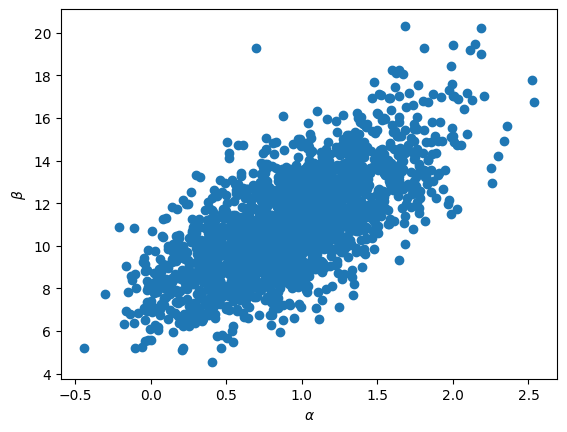

In [6]:
plt.scatter(posterior_alphas, posterior_betas)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.show()

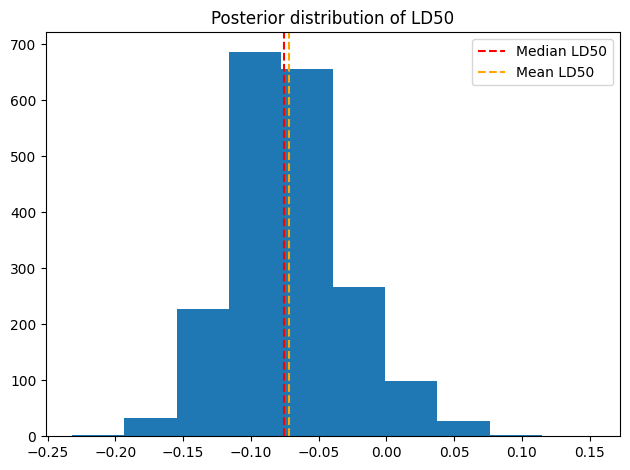

In [7]:
plt.hist(posterior_ld50)
plt.axvline(np.median(posterior_ld50), linestyle="--", color="red", label="Median LD50")
plt.axvline(np.mean(posterior_ld50), linestyle="--", color="orange", label="Mean LD50")
plt.title("Posterior distribution of LD50")
plt.legend()
plt.tight_layout()
plt.show()